In [11]:
import os
from matplotlib import pyplot as plt
import numpy as np
import time as tm
from scipy import interpolate as it
from itertools import chain

In [12]:
# essential functions
def to_wn(value):
    wn = 10 ** 7 / value
    return wn

def to_wl(value):
    wl = 10 ** 7 / value
    return wl

def to_rad(value):
    rad = value * np.pi /180
    return rad

def to_degree(value):
    degree = value * 180 / np.pi
    return degree

def sfg_angle(ir, vis, ir_a, vis_a):
    theta = np.arctan((ir * np.sin(ir_a) + vis * np.sin(vis_a))/(
    ir * np.cos(ir_a) + vis * np.cos(vis_a)))
    return theta

def theta_1(n_1, gamma):
    θ = np.pi / 3 - np.arcsin(1 * np.sin(np.pi / 3 - gamma)/ n_1 )
    return θ

def refract(θ_i, ind_i, ind_j):
    cos_theta_j = np.sqrt(1 - (ind_i ** 2) / (ind_j ** 2) * (np.sin(θ_i) ** 2))
    theta_j = np.arccos(cos_theta_j)
    return theta_j 

In [13]:
path = '/Users/ricoxi/Desktop/Coding/Fresnel Factor/'
os.chdir(path)
import import_ipynb
from d2o_ni_caf2 import mylib

'''
Experimental Parameter
'''
# visible beam centered at
vis_wl = 795.
vis_wn = to_wn(vis_wl)
# thickness of gold
d_gold = 5

# beam angles
θ_1_IR_dg  = 64
θ_1_vis_dg = 47

# list of IR wn of which the final output will be plotted against
IR_wn = [mylib.m1_ir[i][0] for i in range(len(mylib.m1_ir))]
IR_wl = [to_wl(mylib.m1_ir[i][0]) for i in range(len(mylib.m1_ir))]

# list of sfg wn
sfg_wn = [IR_wn[i] + vis_wn for i in range(len(IR_wn))]
sfg_wl = [to_wn(i) for i in sfg_wn]

'''
m1 = SAPPHIRE
m2 = GOLD
m3 = WATER
'''

ind_1_IR = [complex(i[1],i[2]) for i in mylib.m1_ir]
ind_2_IR = [complex(i[1],i[2]) for i in mylib.m2_ir]
ind_3_IR = [complex(i[1],i[2]) for i in mylib.m3_ir]

ind_1_vis = complex(mylib.m1_vis[1],mylib.m1_vis[2])
ind_2_vis = complex(mylib.m2_vis[1],mylib.m2_vis[2])
ind_3_vis = complex(mylib.m3_vis[1],mylib.m3_vis[2])

ind_1_sfg = [complex(i[1],i[2]) for i in mylib.m1_sfg]
ind_2_sfg = [complex(i[1],i[2]) for i in mylib.m2_sfg]
ind_3_sfg = [complex(i[1],i[2]) for i in mylib.m3_sfg]

'''
All the angles in the world
'''
θ_1_IR = [to_rad(θ_1_IR_dg) for i in ind_1_IR]
θ_2_IR = [refract(i[0], i[1], i[2]) for i in zip(θ_1_IR, ind_1_IR, ind_2_IR)]
θ_3_IR = [refract(i[0], i[1], i[2]) for i in zip(θ_2_IR, ind_2_IR, ind_3_IR)]

θ_1_vis = to_rad(θ_1_vis_dg)
θ_2_vis = refract(θ_1_vis, ind_1_vis, ind_2_vis)
θ_3_vis = refract(θ_2_vis, ind_2_vis, ind_3_vis)

θ_1_sfg = [sfg_angle(i[0], vis_wn, i[1], θ_1_vis) for i in zip(IR_wn, θ_1_IR)]
θ_2_sfg = [refract(i[0], i[1], i[2]) for i in zip(θ_1_sfg, ind_1_sfg, ind_2_sfg)]
θ_3_sfg = [refract(i[0], i[1], i[2]) for i in zip(θ_2_sfg, ind_2_sfg, ind_3_sfg)]

In [14]:
'''
Functions of Fresnel Parameters
'''
def r_ij_p(n_i, n_j, theta_i, theta_j):
    r = (n_j * np.cos(theta_i) - n_i * np.cos(theta_j)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
    return r

def r_ij_s(n_i, n_j, theta_i, theta_j):
    r = (n_i * np.cos(theta_i) - n_j * np.cos(theta_j)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
    return r

def t_ij_p(n_i, n_j, theta_i, theta_j):
    t = (2 * n_i * np.cos(theta_i)) / (n_j * np.cos(theta_i) + n_i * np.cos(theta_j))
    return t

def t_ij_s(n_i, n_j, theta_i, theta_j):
    t = (2 * n_i * np.cos(theta_i)) / (n_i * np.cos(theta_i) + n_j * np.cos(theta_j))
    return t

# =========================================== #
def beta(wavelength, n_2, thickness, theta_2):
    β = 2 * np.pi / wavelength * n_2 * thickness * np.cos(theta_2)
    return β

def delta_ir(ir_wl, vis_wl, n_1_ir, n_2_ir, thickness, theta_1_ir, theta_2_ir, theta_2_sfg):
    Δ = (2 * np.pi * n_2_ir * thickness) / (ir_wl * np.cos(theta_2_ir)) - (2 * np.pi * n_1_ir * thickness) / vis_wl * (np.tan(theta_2_ir) + np.tan(theta_2_sfg)) * np.sin(theta_1_ir)
    return Δ

def delta_vis(vis_wl, n_1_vis, n_2_vis, thickness, theta_1_vis, theta_2_vis, theta_2_sfg):
    Δ = (2 * np.pi * n_2_vis * thickness) / (vis_wl * np.cos(theta_2_vis)) - (2 * np.pi * n_1_vis * thickness) / vis_wl * (np.tan(theta_2_vis) + np.tan(theta_2_sfg)) * np.sin(theta_1_vis)
    return Δ

def delta_sfg(sfg_wl, n_2_sfg, thickness, theta_2_sfg):
    Δ = (2 * np.pi * n_2_sfg * thickness) / (sfg_wl * np.cos(theta_2_sfg)) 
    return Δ

# =========================================== #
def L_I_xx(t_12_p, r_12_p, r_23_p, beta, theta_2, theta_1):
    L = (t_12_p) / (1 + r_12_p * r_23_p * np.e **(2j * beta)) * (1 - r_23_p * np.e ** (2j * beta)) * np.cos(theta_2) / np.cos(theta_1)
    return L

def L_I_yy(t_12_s, r_12_s, r_23_s, beta):
    L = (t_12_s) / (1 + r_12_s * r_23_s * np.e **(2j * beta)) * (1 + r_23_s * np.e **(2j * beta))
    return L

def L_I_zz(t_12_p, r_12_p, r_23_p, beta, n_1, n_2, n_int_I):
    L = (t_12_p) / (1 + r_12_p * r_23_p * np.e **(2j * beta)) * (1 + r_23_p * np.e **(2j * beta)) * (n_1 * n_2) / (n_int_I ** 2)
    return L

def L_II_xx(delta, t_12_p, r_12_p, r_23_p, beta, theta_2, theta_1):
    L = np.e ** (1j * delta) * (t_12_p) / (1 + r_12_p * r_23_p * np.e **(2j * beta)) * (1 - r_23_p) * np.cos(theta_2) / np.cos(theta_1)
    return L

def L_II_yy(delta, t_12_s, r_12_s, r_23_s, beta):
    L = np.e ** (1j * delta) * (t_12_s) / (1 + r_12_s * r_23_s * np.e **(2j * beta)) * (1 + r_23_s)
    return L

def L_II_zz(delta, t_12_p, r_12_p, r_23_p, beta, n_1, n_2, n_int_II):
    L = np.e ** (1j * delta) * (t_12_p) / (1 + r_12_p * r_23_p * np.e **(2j * beta)) * (1 + r_23_p) * (n_1 * n_2) / (n_int_II ** 2)
    return L
# =========================================== #
def check(r, t, n_1, theta_1, n_2, theta_2):
    R = r * r.conjugate()
    T = t * t.conjugate() * (n_2 * np.cos(theta_2)) / (n_1 * np.cos(theta_1))
    return T + R

In [15]:
'''
Calculations of Fresnel Parameters
'''
# =========================================== #
β_ir = [beta(i[0], i[1], d_gold, i[2]) for i in zip(IR_wl, ind_2_IR, θ_2_IR)]
Δ_ir = [delta_ir(i[0], vis_wl, i[1], i[2], d_gold, i[3], i[4], i[5])
       for i in zip(IR_wl, ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR, θ_2_sfg)]

β_vis = beta(vis_wl, ind_2_vis, d_gold, θ_2_vis)
Δ_vis = delta_vis(vis_wl, ind_1_vis, ind_2_vis, d_gold, θ_1_vis, θ_2_vis, θ_2_sfg)

β_sfg = [beta(i[0], i[1], d_gold, i[2]) for i in zip(sfg_wl, ind_2_sfg, θ_2_sfg)]
Δ_sfg = [delta_sfg(i[0], i[1], d_gold, i[2])
       for i in zip(sfg_wl, ind_2_sfg, θ_2_sfg)]
# =========================================== #
r_12_p_ir = [r_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
t_12_p_ir = [t_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
r_23_p_ir = [r_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
t_23_p_ir = [t_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]

r_12_s_ir = [r_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
t_12_s_ir = [t_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_IR, ind_2_IR, θ_1_IR, θ_2_IR)]
r_23_s_ir = [r_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
t_23_s_ir = [t_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_IR, ind_3_IR, θ_2_IR, θ_3_IR)]
# =========================================== #
L_I_xx_ir = [L_I_xx(i[0],i[1],i[2],i[3],i[4],i[5]) 
              for i in zip(t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, θ_2_IR, θ_1_IR)]
L_I_yy_ir = [L_I_yy(i[0],i[1],i[2],i[3])
              for i in zip(t_12_s_ir, r_12_s_ir, r_23_s_ir, β_ir)]
L_I_zz_ir = [L_I_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
              for i in zip(t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_2_IR)]

L_II_xx_ir = [L_II_xx(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
              for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, θ_2_IR, θ_1_IR)]
L_II_yy_ir = [L_II_yy(i[0],i[1],i[2],i[3],i[4])
              for i in zip(Δ_ir, t_12_s_ir, r_12_s_ir, r_23_s_ir, β_ir)]
# chi(2) water is large chi(2) nickel, 
L_II_zz_ir_d2o = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
              for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_3_IR)]
# # chi(2) nickel is large chi(2) water, 
L_II_zz_ir_n   = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
              for i in zip(Δ_ir, t_12_p_ir, r_12_p_ir, r_23_p_ir, β_ir, ind_1_IR, ind_2_IR, ind_2_IR)]
L_II_zz_ir = {'d2o': L_II_zz_ir_d2o, 'nickel': L_II_zz_ir_n}
# =========================================== #
L_I_xx_ir_sq = [i * i.conjugate() for i in L_I_xx_ir]
L_I_yy_ir_sq = [i * i.conjugate() for i in L_I_yy_ir]
L_I_zz_ir_sq = [i * i.conjugate() for i in L_I_zz_ir]

L_II_xx_ir_sq = [i * i.conjugate() for i in L_II_xx_ir]
L_II_yy_ir_sq = [i * i.conjugate() for i in L_II_yy_ir]
L_II_zz_ir_sq = {'d2o': [i * i.conjugate() for i in L_II_zz_ir['d2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_ir['nickel']]}

# ====================================================================================== #
# ====================================================================================== #
# ====================================================================================== #
r_12_p_vis = r_ij_p(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
t_12_p_vis = t_ij_p(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
r_23_p_vis = r_ij_p(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
t_23_p_vis = t_ij_p(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)

r_12_s_vis = r_ij_s(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
t_12_s_vis = t_ij_s(ind_1_vis, ind_2_vis, θ_1_vis, θ_2_vis)
r_23_s_vis = r_ij_s(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
t_23_s_vis = t_ij_s(ind_2_vis, ind_3_vis, θ_2_vis, θ_3_vis)
# =========================================== #
L_I_xx_vis = [L_I_xx(t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, θ_2_vis, θ_1_vis) for i in ind_1_IR]
L_I_yy_vis = [L_I_yy(t_12_s_vis, r_12_s_vis, r_23_s_vis, β_vis) for i in ind_1_IR]
L_I_zz_vis = [L_I_zz(t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_2_vis) for i in ind_1_IR]

L_II_xx_vis = [L_II_xx(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, θ_2_vis, θ_1_vis)]
L_II_xx_vis = list(chain.from_iterable(L_II_xx_vis))
L_II_yy_vis = [L_II_yy(Δ_vis, t_12_s_vis, r_12_s_vis, r_23_s_vis, β_vis)]
L_II_yy_vis = list(chain.from_iterable(L_II_yy_vis))
# chi(2) water is large chi(2) nickel, 
L_II_zz_vis_d2o = [L_II_zz(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_3_vis)]
L_II_zz_vis_d2o = list(chain.from_iterable(L_II_zz_vis_d2o))
# # chi(2) nickel is large chi(2) water, 
L_II_zz_vis_n   = [L_II_zz(Δ_vis, t_12_p_vis, r_12_p_vis, r_23_p_vis, β_vis, ind_1_vis, ind_2_vis, ind_2_vis)]
L_II_zz_vis_n = list(chain.from_iterable(L_II_zz_vis_n))
L_II_zz_vis = {'d2o': L_II_zz_vis_d2o, 'nickel': L_II_zz_vis_n}
# =========================================== #
L_I_xx_vis_sq = [i * i.conjugate() for i in L_I_xx_vis]
L_I_yy_vis_sq = [i * i.conjugate() for i in L_I_yy_vis]
L_I_zz_vis_sq = [i * i.conjugate() for i in L_I_zz_vis]

L_II_xx_vis_sq = [i * i.conjugate() for i in L_II_xx_vis]
L_II_yy_vis_sq = [i * i.conjugate() for i in L_II_yy_vis]
L_II_zz_vis_sq = {'d2o': [i * i.conjugate() for i in L_II_zz_vis['d2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_vis['nickel']]}
# ====================================================================================== #
# ====================================================================================== #
# ====================================================================================== #
r_12_p_sfg = [r_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
t_12_p_sfg = [t_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
r_23_p_sfg = [r_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
t_23_p_sfg = [t_ij_p(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]

r_12_s_sfg = [r_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
t_12_s_sfg = [t_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_1_sfg, ind_2_sfg, θ_1_sfg, θ_2_sfg)]
r_23_s_sfg = [r_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
t_23_s_sfg = [t_ij_s(i[0], i[1], i[2], i[3]) 
             for i in zip(ind_2_sfg, ind_3_sfg, θ_2_sfg, θ_3_sfg)]
# =========================================== #
L_I_xx_sfg = [L_I_xx(i[0],i[1],i[2],i[3],i[4],i[5]) 
              for i in zip(t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, θ_2_sfg, θ_1_sfg)]
L_I_yy_sfg = [L_I_yy(i[0],i[1],i[2],i[3])
              for i in zip(t_12_s_sfg, r_12_s_sfg, r_23_s_sfg, β_sfg)]
L_I_zz_sfg = [L_I_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
              for i in zip(t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_1_sfg)]

L_II_xx_sfg = [L_II_xx(i[0],i[1],i[2],i[3],i[4],i[5],i[6]) 
              for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, θ_2_sfg, θ_1_sfg)]
L_II_yy_sfg = [L_II_yy(i[0],i[1],i[2],i[3],i[4])
              for i in zip(Δ_sfg, t_12_s_sfg, r_12_s_sfg, r_23_s_sfg, β_sfg)]
# chi(2) water is large chi(2) nickel, 
L_II_zz_sfg_d2o = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
              for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_3_sfg)]
# # chi(2) nickel is large chi(2) water, 
L_II_zz_sfg_n   = [L_II_zz(i[0],i[1],i[2],i[3],i[4],i[5],i[6], i[7]) 
              for i in zip(Δ_sfg, t_12_p_sfg, r_12_p_sfg, r_23_p_sfg, β_sfg, ind_1_sfg, ind_2_sfg, ind_2_sfg)]
L_II_zz_sfg = {'d2o': L_II_zz_sfg_d2o, 'nickel': L_II_zz_sfg_n}
# =========================================== #
L_I_xx_sfg_sq  = [i * i.conjugate() for i in L_I_xx_sfg]
L_I_yy_sfg_sq  = [i * i.conjugate() for i in L_I_yy_sfg]
L_I_zz_sfg_sq  = [i * i.conjugate() for i in L_I_zz_sfg]

L_II_xx_sfg_sq = [i * i.conjugate() for i in L_II_xx_sfg]
L_II_yy_sfg_sq = [i * i.conjugate() for i in L_II_yy_sfg]
L_II_zz_sfg_sq = {'d2o': [i * i.conjugate() for i in L_II_zz_sfg['d2o']], 'nickel': [i * i.conjugate() for i in L_II_zz_sfg['nickel']]}

L_ir_d = [[L_I_xx_ir_sq, L_I_yy_ir_sq], [L_II_xx_ir_sq, L_II_yy_ir_sq]]

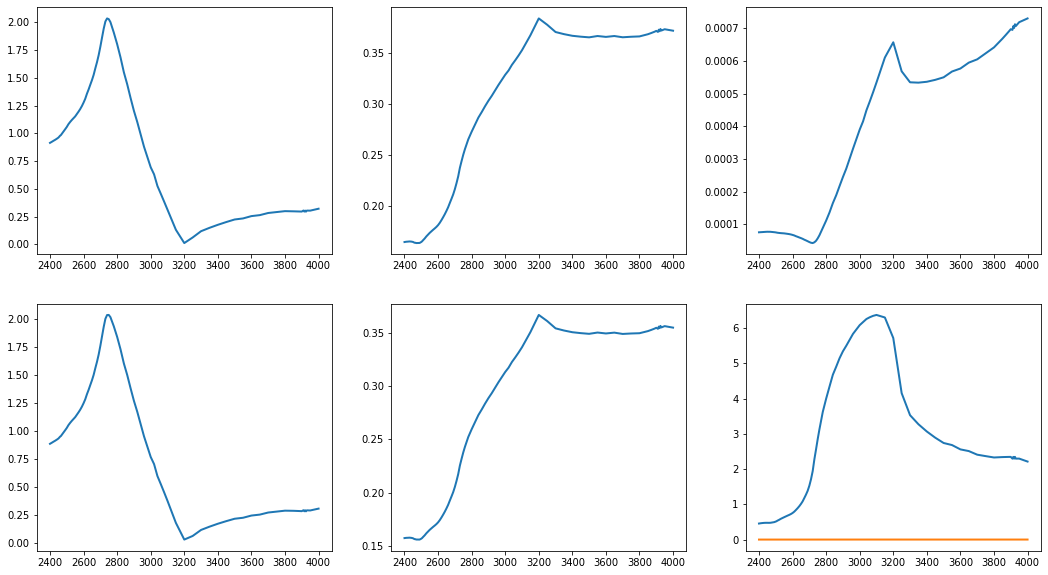

In [16]:
fsize = (18,10)
lw = 2
fig, ax = plt.subplots(2,3, figsize=fsize, sharey=False, sharex=False)
ax[0,0].plot(IR_wn, [i.real for i in L_I_xx_ir_sq], linewidth = lw)
ax[0,1].plot(IR_wn, [i.real for i in L_I_yy_ir_sq], linewidth = lw)
ax[0,2].plot(IR_wn, [i.real for i in L_I_zz_ir_sq], linewidth = lw)
ax[1,0].plot(IR_wn, [i.real for i in L_II_xx_ir_sq], linewidth = lw)
ax[1,1].plot(IR_wn, [i.real for i in L_II_yy_ir_sq], linewidth = lw)
ax[1,2].plot(IR_wn, [i.real for i in L_II_zz_ir_sq['d2o']], IR_wn, [i.real for i in L_II_zz_ir_sq['nickel']], linewidth = lw)

In [17]:
'''
SFG intensity Scalars
'''
def ssp(yy_sfg, yy_vis, zz_ir, theta_ir):
    a = np.sin(theta_ir) * np.sin(theta_ir).conjugate()
    scalar = yy_sfg.real * yy_vis.real * zz_ir.real * a.real
    return scalar

def sps(yy_sfg, zz_vis, yy_ir, theta_vis):
    a = np.sin(theta_vis) * np.sin(theta_vis).conjugate()
    scalar = yy_sfg.real * zz_vis.real * yy_ir.real * a.real
    return scalar

def pss(zz_sfg, yy_vis, yy_ir, theta_sfg):
    a = np.sin(theta_sfg) * np.sin(theta_sfg).conjugate()
    scalar = zz_sfg.real * yy_vis.real * yy_ir.real * a.real
    return scalar

def ppp_xxz(xx_sfg,xx_vis,zz_ir,theta_sfg,theta_vis,theta_ir):
    a = np.cos(theta_sfg) * np.cos(theta_sfg).conjugate()
    b = np.cos(theta_vis) * np.cos(theta_vis).conjugate()
    c = np.sin(theta_ir) * np.sin(theta_ir).conjugate()
    scalar = xx_sfg.real*xx_vis.real*zz_ir.real*a.real*b.real*c.real
    return scalar

def ppp_xzx(xx_sfg,zz_vis,xx_ir,theta_sfg,theta_vis,theta_ir):
    a = np.cos(theta_sfg) * np.cos(theta_sfg).conjugate()
    b = np.sin(theta_vis) * np.sin(theta_vis).conjugate()
    c = np.cos(theta_ir) * np.cos(theta_ir).conjugate()
    scalar = xx_sfg.real*zz_vis.real*xx_ir.real*a.real*b.real*c.real
    return scalar

def ppp_zxx(zz_sfg,xx_vis,xx_ir,theta_sfg,theta_vis,theta_ir):
    a = np.sin(theta_sfg) * np.sin(theta_sfg).conjugate()
    b = np.cos(theta_vis) * np.cos(theta_vis).conjugate()
    c = np.cos(theta_ir) * np.cos(theta_ir).conjugate()
    scalar = zz_sfg.real*xx_vis.real*xx_ir.real*a.real*b.real*c.real
    return scalar

def ppp_zzz(zz_sfg,zz_vis,zz_ir,theta_sfg,theta_vis,theta_ir):
    a = np.sin(theta_sfg) * np.sin(theta_sfg).conjugate()
    b = np.sin(theta_vis) * np.sin(theta_vis).conjugate()
    c = np.sin(theta_ir) * np.sin(theta_ir).conjugate()
    scalar = zz_sfg.real*zz_vis.real*zz_ir.real*a.real*b.real*c.real
    return scalar

In [18]:
'''
Scalar Calculation
'''
θ_1_vis = [to_rad(θ_1_vis_dg) for i in ind_1_IR]
θ_2_vis = [(0.008685038014422192-0.22020792437039333j) for i in ind_1_IR]
# =========================================== #
SSP_I = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_I_yy_sfg_sq,L_I_yy_vis_sq, L_I_zz_ir_sq, θ_1_IR)]
SPS_I = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_I_yy_sfg_sq, L_I_zz_vis_sq, L_I_yy_ir_sq, θ_1_vis)]
PSS_I = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_I_zz_sfg_sq, L_I_yy_vis_sq, L_I_yy_ir_sq, θ_1_sfg)]
PPP_I_xxz = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_I_xx_sfg_sq, L_I_xx_vis_sq, L_I_zz_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
PPP_I_xzx = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_I_xx_sfg_sq, L_I_zz_vis_sq, L_I_xx_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
PPP_I_zxx = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_I_zz_sfg_sq, L_I_xx_vis_sq, L_I_xx_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]
PPP_I_zzz = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_I_zz_sfg_sq, L_I_zz_vis_sq, L_I_zz_ir_sq, θ_1_sfg, θ_1_vis, θ_1_IR)]

# =========================================== #
# chi(2) nickel is large than water/d2o
# L_II_zz takes in nickel as n_int_II
SSP_II_n = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_yy_vis_sq, L_II_zz_ir_sq['nickel'], θ_2_IR)]
SPS_II_n = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_zz_vis_sq['nickel'], L_II_yy_ir_sq, θ_2_vis)]
PSS_II_n = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_II_zz_sfg_sq['nickel'], L_II_yy_vis_sq, L_II_yy_ir_sq, θ_2_sfg)]
PPP_II_xxz_n = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_xx_sfg_sq, L_II_xx_vis_sq, L_II_zz_ir_sq['nickel'], θ_2_sfg, θ_2_vis, θ_2_IR)]
PPP_II_xzx_n = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_xx_sfg_sq, L_II_zz_vis_sq['nickel'], L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
PPP_II_zxx_n = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_zz_sfg_sq['nickel'], L_II_xx_vis_sq, L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
PPP_II_zzz_n = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_zz_sfg_sq['nickel'], L_II_zz_vis_sq['nickel'], L_II_zz_ir_sq['nickel'], θ_2_sfg, θ_2_vis, θ_2_IR)]

# =========================================== #
# chi(2) nickel is large than water/d2o
# L_II_zz takes in d2o as n_int_II
SSP_II_d = [ssp(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_yy_vis_sq, L_II_zz_ir_sq['d2o'], θ_2_IR)]
SPS_II_d = [sps(i[0],i[1],i[2],i[3]) for i in zip(L_II_yy_sfg_sq, L_II_zz_vis_sq['d2o'], L_II_yy_ir_sq, θ_2_vis)]
PSS_II_d = [pss(i[0],i[1],i[2],i[3]) for i in zip(L_II_zz_sfg_sq['d2o'], L_II_yy_vis_sq, L_II_yy_ir_sq, θ_2_sfg)]
PPP_II_xxz_d = [ppp_xxz(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_xx_sfg_sq, L_II_xx_vis_sq, L_II_zz_ir_sq['d2o'], θ_2_sfg, θ_2_vis, θ_2_IR)]
PPP_II_xzx_d = [ppp_xzx(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_xx_sfg_sq, L_II_zz_vis_sq['d2o'], L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
PPP_II_zxx_d = [ppp_zxx(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_zz_sfg_sq['d2o'], L_II_xx_vis_sq, L_II_xx_ir_sq, θ_2_sfg, θ_2_vis, θ_2_IR)]
PPP_II_zzz_d = [ppp_zzz(i[0],i[1],i[2],i[3],i[4],i[5])
             for i in zip(L_II_zz_sfg_sq['d2o'], L_II_zz_vis_sq['d2o'], L_II_zz_ir_sq['d2o'], θ_2_sfg, θ_2_vis, θ_2_IR)]

df_d = [[SSP_I, SPS_I, PSS_I, PPP_I_xxz, PPP_I_xzx, PPP_I_zxx, PPP_I_zzz],
      [SSP_II_n, SPS_II_n, PSS_II_n, PPP_II_xxz_n, PPP_II_xzx_n, PPP_II_zxx_n, PPP_II_zzz_n],
      [SSP_II_d, SPS_II_d, PSS_II_d, PPP_II_xxz_d, PPP_II_xzx_d, PPP_II_zxx_d, PPP_II_zzz_d]]

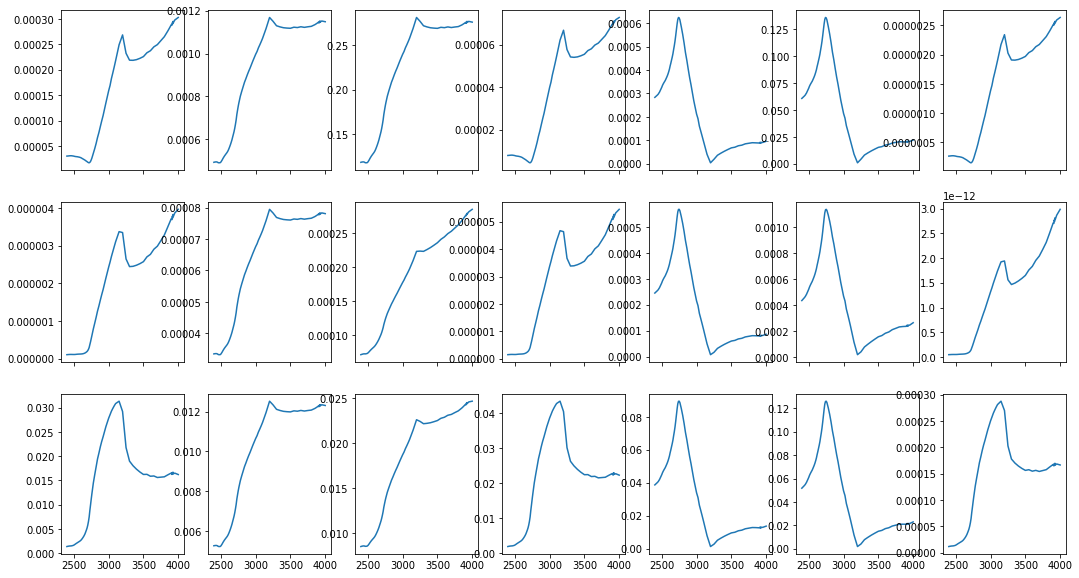

In [19]:
big, bx = plt.subplots(3,7, figsize=fsize, sharey=False, sharex=True)
for ii in range(3):
    for jj in range(7):
        bx[ii,jj].plot(IR_wn, df_d[ii][jj])

In [26]:
from FC_h2o_ni_caf2 import df_h,L_ir_w

In [27]:
IR_wn_h = [2400.0,
 2450.0,
 2500.0,
 2550.0,
 2600.0,
 2650.0,
 2700.0,
 2750.0,
 2800.0,
 2840.0,
 2880.0,
 2920.0,
 2960.0,
 3000.0,
 3040.0,
 3060.0,
 3100.0,
 3140.0,
 3160.0,
 3180.0,
 3210.0,
 3220.0,
 3240.0,
 3260.0,
 3280.0,
 3300.0,
 3320.0,
 3340.0,
 3360.0,
 3380.0,
 3390.0,
 3400.0,
 3410.0,
 3420.0,
 3440.0,
 3460.0,
 3480.0,
 3500.0,
 3520.0,
 3540.0,
 3560.0,
 3580.0,
 3600.0,
 3640.0,
 3680.0,
 3720.0,
 3760.0,
 3800.0,
 4000.0]

In [28]:
df_d_new = [[],[],[]]
for ii in range(3):
    for jj in range(7):
        x = IR_wn
        y = df_d[ii][jj]
        f = it.interp1d(x,y)
        target_len = 32
        x_new = np.arange(2400,4001,target_len)
        y_new = f(x_new)
        df_d_new[ii].append(y_new)

df_h_new = [[],[],[]]
for ii in range(3):
    for jj in range(7):
        x = IR_wn_h
        y = df_h[ii][jj]
        f = it.interp1d(x,y)
        target_len = 32
        x_new = np.arange(2400,4001,target_len)
        y_new = f(x_new)
        df_h_new[ii].append(y_new)

In [29]:
target_len = 32
x_new = np.arange(2400,4001,target_len)
ratio = [[],[],[]]
for ii in range(3):
    for jj in range(7):
        val = df_h_new[ii][jj] / df_d_new[ii][jj]
        ratio[ii].append(val)

(0, 10)

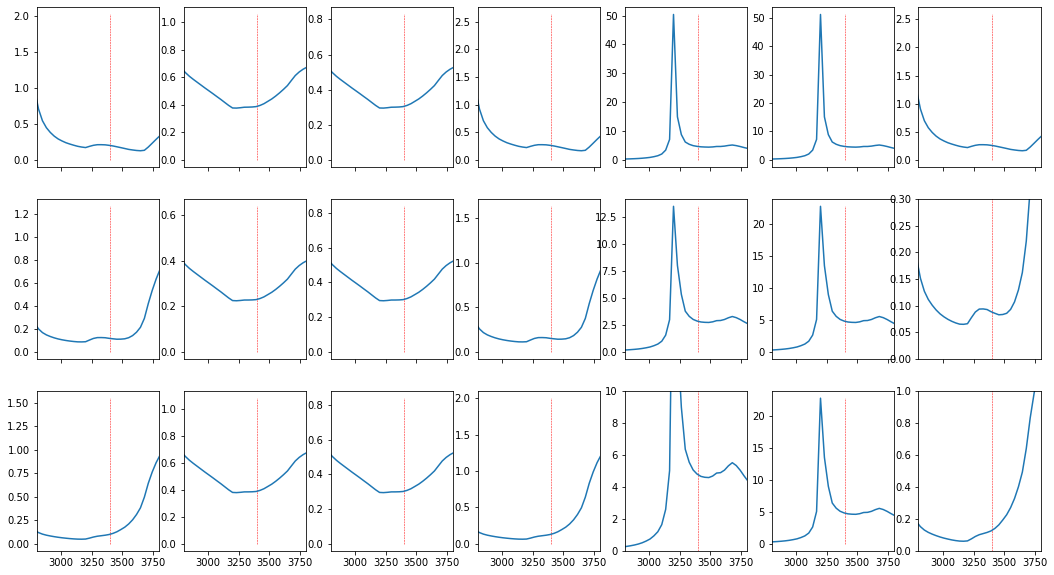

In [30]:
cig, cx = plt.subplots(3,7, figsize=fsize, sharey=False, sharex=True)
for ii in range(3):
    for jj in range(7):
        cx[ii,jj].plot(x_new, ratio[ii][jj])
        cx[ii,jj].set_xlim(2800,3800)
        cx[ii,jj].vlines(3400, 0, max(ratio[ii][jj]), 'red', '--', linewidth= 0.5)
        
cx[1,6].set_ylim(0,0.3)
cx[2,6].set_ylim(0,1)
cx[2,4].set_ylim(0, 10)

In [31]:
L_d_new = [[],[]]
for ii in range(2):
    for jj in range(2):
        x = IR_wn
        y = L_ir_d[ii][jj]
        f = it.interp1d(x,y)
        target_len = 32
        x_new = np.arange(2400,4001,target_len)
        y_new = f(x_new)
        L_d_new[ii].append(y_new)

L_h_new = [[],[]]
for ii in range(2):
    for jj in range(2):
        x = IR_wn_h
        y = L_ir_w[ii][jj]
        f = it.interp1d(x,y)
        target_len = 32
        x_new = np.arange(2400,4001,target_len)
        y_new = f(x_new)
        L_h_new[ii].append(y_new)

In [38]:
target_len = 32
x_new = np.arange(2400,4001,target_len)
L_ratio = [[],[]]
for ii in range(2):
    for jj in range(2):
        val = L_h_new[ii][jj] / L_d_new[ii][jj]
        L_ratio[ii].append(val.real)

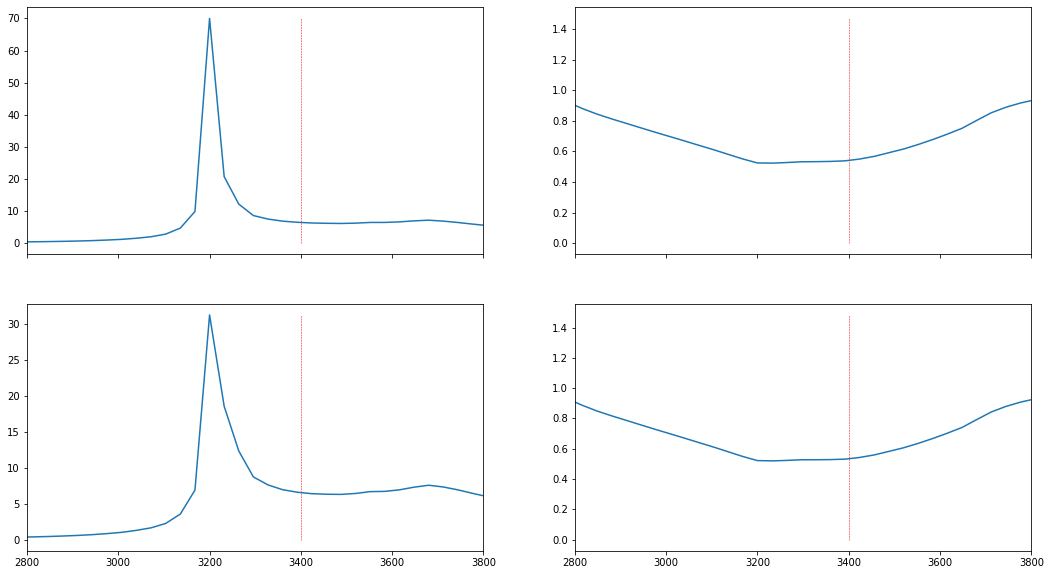

In [41]:
dig, dx = plt.subplots(2,2, figsize=fsize, sharey=False, sharex=True)
for ii in range(2):
    for jj in range(2):
        dx[ii,jj].plot(x_new, L_ratio[ii][jj])
        dx[ii,jj].set_xlim(2800,3800)
        dx[ii,jj].vlines(3400, 0, max(L_ratio[ii][jj]), 'red', '--', linewidth= 0.5)
        
# dx[1,6].set_ylim(0,0.3)
# dx[2,6].set_ylim(0,1)
# dx[2,4].set_ylim(0, 10)